#__CHAP 3. 분류__

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

##__1. MNIST__
* MNIST 데이터셋 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지 데이터
  * 각 숫자에는 어떤 숫자인지 레이블이 존재

In [3]:
# sklearn으로 MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [30]:
X, y = mnist["data"], mnist["target"]
X=X.to_numpy()
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


* 70000개 이미지, 784개 특성 (28*28)
  * 각 특성은 0~225 까지의 픽셀 강도(진하기)를 표현
  

In [31]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

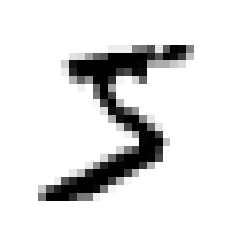

In [33]:
# 이미지 하나 확인
# 샘플의 특성 벡터를 추출해서 28*28 배열로 크기를 바꾸고 맷플롯립의 imshow()함수 사용

some_digit=X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [34]:
y[0]
y=y.astype(np.uint8)

In [36]:
# 테스트 데이터 세트 분리
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

##__2. 이진 분류기 훈련__

* 5-감지기 : 5와 5가 아닌 숫자를 분류하는 이진 분류기

In [37]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

 * SGDClassifier 클래스 사용

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [40]:
#모델을 사용해 숫자 5의 이미지를 감지
sgd_clf.predict([some_digit])

array([ True])

##__3. 성능 측정__


###1) 교차 검증을 사용한 정확도 측정


* 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 경우 직접 교차검증을 구현
* StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함

In [43]:
# 교차검증 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct /len(y_pred))

0.95035
0.96035
0.9604


* cross_val_score() 함수로 폴드가 3개인 k-fold 교차 검증을 사용해 SGDClassifier 모델을 평가
* k-fold 교차 검증은 훈련 세트를 k개의 폴드로 나누어 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

> 모든 교차 검증 폴드에 대해 정확도가 95% 이상

* 모든 이미지를 무조건 '5 아님' 클래스로 분류하는 더미 분류기

In [46]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1), dtype=bool)

In [47]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

> 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%

* 특히 불균형한 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않음

###2) 오차 행렬

* 클래스 A의 샘플이 클래스 B로 분류된 횟수 측정

* 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
  * 테스트세트는 여기서 사용하면 안됨 >> cross_val_predict() 함수 사용

* cross_val_predict()
  * cross_val_score() 함수처럼 k-fold 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [48]:
from  sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 오차 행렬의 행 : 실제 클래스
* 오차 행렬을 열 : 예측한 클래스

In [49]:
#완벽한 분류기일 경우
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 정밀도 : 양성 예측의 정확도
  * 정밀도 = (실제양성&예측양성)/(예측양성)
  * 예측 양성이 실제 양성일 확률

* 재현율(민감도) : 분류기가 정확하게 감지한 양성 샘플의 비율
  * 재현율 = (실제양성&예측양성)/(실제양성) 
  * 실제 양성을 양성으로 예측할 확률

###3) 정밀도와 재현율

In [50]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


> 5로 판별된 이미지 중 83%만 정확함

> 전체 5 이미지 중에서 65%만 감지함

* F1-score
  * 정밀도와 재현율의 조화평균
  * F1-score=2/((1/정밀도)+(1/재현율))

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

* 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음

* 상황에 따라 정밀도가 중요할 수 도 있고 재현율이 중요할수도 있음

###4) 정밀도/재현율 트레이드오프

* SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수를 계산 > 점수가 임곗값보다 크면 양성으로 분류
  * 임곗값이 커지면 
    - 실제양성을 음성으로 예측할 확률이 높아짐 > 재현율 감소
    - 실제음성을 음성으로 예측할 확률이 높아짐 > 정밀도 증가
  * 임곗값이 작아지면
    - 실제음성을 양성으로 예측할 확률이 높아짐 > 정밀도 감소
    - 실제양성을 양성으로 예측할 확률이 높아짐 > 재현율 증가


* 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음
  * 분류기의 predict() 대신 decision_function() 메서드를 호출 > 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

In [55]:
y_scores=sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred=(y_scores>threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


> SGDClassifier의 임곗값이 0 >> predict()와 같은 결과

In [57]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
print(y_some_digit_pred)

[False]


> 임곗값을 높이면 재현율이 줄어듦

* 적절한 임곗값 알아보기
  * 모든 샘플에 대한 결정 점수를 구해 모든 임곗값에 대해 정밀도와 재현율을 계산

In [58]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [59]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

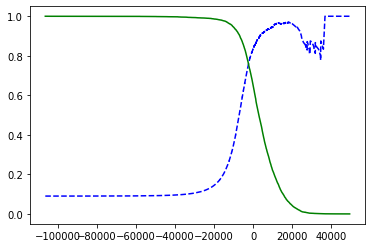

In [62]:
#맷플롯립으로 함수의 정밀도와 재현율 그래프 그리기
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds, precisions[:-1], "b--",label="정밀도")
  plt.plot(thresholds, recalls[:-1],"g-",label="재현율")
  [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> 정밀도는 임곗값이 증가함에 따라 낮아질수도 있음

* 재현율에 대한 정밀도 곡선 그리기
  * 정밀도가 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드오프로 선택

In [64]:
# 정밀도 목푯값에 따른 임곗값 찾기 (90% 정밀도)
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
print(threshold_90_precision)

3370.0194991439557


* 훈련 세트에 대한 예측 만들기

In [66]:
y_train_pred_90=(y_scores>=threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


* 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않음

###5) ROC 곡선

* 거짓 양성 비율에 대한 진짜 양성 비율의 곡선

In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


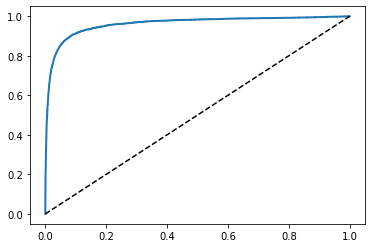

In [68]:
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  [...]

plot_roc_curve(fpr,tpr)
plt.show()

* 재현율(tpr)이 높을수록 분류기가 만드는 거짓 양성(fpr)이 늘어남

* 점선 : 완전한 랜덤 분류기의 ROC곡선
  * 좋은 부류기는 점선에서 최대한 멀리 떨어져 있어야 함

* 곡선 아래의 면적 AUC 로 분류기를 비교
  * 완벽한 분류기는 ROC의 AUC가 1

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함

* RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 AUC 점수를 비교
  * predict_proba() 사용하여 결정 점수 구하기 

* predict_proba() : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환


In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

* roc_curve() 함수에 점수 대신 클래스 확률을 전달

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_

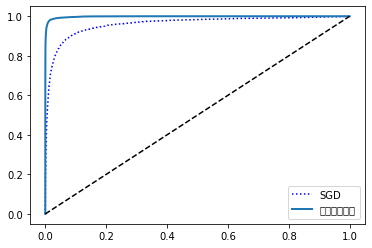

In [71]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"랜덤포레스트")
plt.legend(loc="lower right")
plt.show()

> 랜덤포레스트가 SGD보다 더 좋아 보임

In [72]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

* 이진 분류기를 훈련시키는 방법 / 작업에 맞는 적절한 지표 선택 / 교차 검증을 사용한 평가 / 요구 사항에 맞는 정밀도,재현율 트레이드 오프 선택 / ROC 곡선과 AUC 점수를 사용한 여러 모델의 비교

##__4. 다중 분류__

* 둘 이상의 클래스를 구별

* SGD분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기와 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리 가능
* 로지스틱 회귀나 서포트 벡터 머신 분류기와 같은 알고리즘은 이진 분류만 가능함 (여러 개의 이진 분류기로 다중 분류 가능)

  * OvR(OvA) 전략
    * 각 클래스 하나씩만 분류하는 여러 개의 이진 분류기를 훈련시켜 각 분류기의 결정 점수 중에서 점수가 가장 높은 것을 예측 클래스로 선택
  * OvO 전략
    * 각 클래스의 조합마다 이진 분류기를 훈련시켜 가장 많이 양성으로 분류된 클래스를 선택 

* SVM 같은 일부 알고리즘은 훈련 세트의 크기에 민감 > OvO선호

* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR또는 OvO를 실행

In [73]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [74]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

> 샘플 당 10개의 결정 점수를 반환

In [77]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


* 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 이진 분류기 인스턴스를 만들어 객체를 생성할때 전달

In [78]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


In [ ]:
#SGDClassifier
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

> 클래스마다 부여한 점수 확인 가능

* 분류기 평가
  * 일반적으로 교차검증 사용

In [ ]:
cross_val_score(sgd_clf,X_train,y_train, cv=3, scoring="accuracy")

In [ ]:
# 입력 스케일을 조정해 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

##__5. 에러 분석__

* 가능성이 높은 모델을 하나 찾았다고 가정하고 에러의 종류를 분석하여 이 모델의 성능을 향상시킬 방법 찾기

* 오차 행렬

In [ ]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

In [ ]:
# 오차 행렬을 matshow()를 이용하여 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* 에러의 비율 비교
  * 오차 행렬의 각 값을 대응되는 클래스의 이미지 갯수로 나누기

In [ ]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

In [ ]:
# 주대각선만 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음
  * ex. 잘못 분류하는 경우가 많은 클래스에 대해 해당 클래스의 훈련 데이터를 더 많이 모아 분류기를 학습

* 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있지만 더 어렵고 시간이 오래 걸림
  * 3과 5의 샘플

In [ ]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train==cl_a)& (y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)& (y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)& (y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)& (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5)
plt.show()

> 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함 > 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

###__6. 다중 레이블 분류__


* 분류기가 샘플마다 여러 개의 클래스를 출력
  * ex. 앨리스, 밥, 찰리에 대한 얼굴 인식 분류기 > 사진에 앨리스, 찰리가 있다면 [1,0,1] 출력

* 다중 레이블 분류
  * 여러 개의 이진 꼬리표를 출력하는 분류 시스템

* 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열
  * 숫자가 7,8,9의 큰 값인지
  * 숫자가 홀수인지

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
# F1-score의 평균을 이용하여 다중 레이블 분류기를 평가 
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel,y_train_knn_pred, average="macro")

* average="weighted" >> 특정 클래스의 지지도를 분류기의 점수에 가중치로 반영

##__7. 다중 출력 분류__

* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

* 이미지에서 잡음을 제거하는 시스템
  * 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
  * 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0~255)

In [ ]:
#MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 잡음을 추가
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [ ]:
# 분류기를 훈련시켜 이미지를 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_Test_mod[some_index]])
plot_digit(clean_digit)